# Einleitung zum Versuch "Aggregation and Performance Metrics"

Mit diesem Versuchspaket erhaltet ihr ein umfassendes Verständnis für die Vorteile der Zeitaggregation und die Berechnung von Performance-Metriken in der atmosphärischen Messtechnik. Ihr lernt, wie ihr hochfrequente Sensordaten, die mit Rauschen behaftet sind, aggregiert, um klarere Trends und stabilere Signale zu erhalten, und wie ihr wichtige Kennzahlen wie den Mittelwert, den Mean Absolute Error (MAE) und den Root Mean Squared Error (RMSE) zur Bewertung der Signalqualität einsetzt.

## Hintergrund und Motivation

Moderne Sensorsysteme liefern oftmals Daten mit hoher zeitlicher Auflösung (1-Minuten-Daten), die aufgrund zufälliger Schwankungen und Rauschen schwer zu interpretieren sind. Durch die zeitliche Aggregation – etwa zu stündlichen Mittelwerten – wird das Rauschen reduziert und der zugrunde liegende Trend wird besser sichtbar. 

Darüber versuchen wir die Performance zweier $CO_2$ Sensoren (Vaisala GMP343) gegenüber eines teuren $CO_2$ Referenz Sensors (Picarro G2401) zu verstehen. Hierfür nutzen wir unterschiedliche Berechnungen: Mittelwert, den MAE (Mean Absolute Error), und den RMSE (Root Mean Squared Error).

Diese Kennzahlen helfen, die Qualität und Genauigkeit des aggregierten Signals zu bewerten und unterschiedliche Messsysteme miteinander zu vergleichen.

In [46]:
import polars as pl
import os
import sys
from hampel import hampel
import numpy as np
import polars.selectors as cs

# Add the parent directory to the system path
PROJECT_PATH = os.path.abspath(os.path.join(".."))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from utils.plot_dataframes import plot_column, plot_columns, plot_column_difference

In [35]:
df_p = pl.read_parquet("../data/3_Aggregation_And_Performance_Metrics/Reference_Picarro_G2401.parquet")
df_s_3 = pl.read_parquet("../data/3_Aggregation_And_Performance_Metrics/Sensor_3_GMP343_Measurement.parquet") \
    .join(df_p, on="datetime", how="left")
df_s_6 = pl.read_parquet("../data/3_Aggregation_And_Performance_Metrics/Sensor_6_GMP343_Measurement.parquet") \
    .join(df_p, on="datetime", how="left")

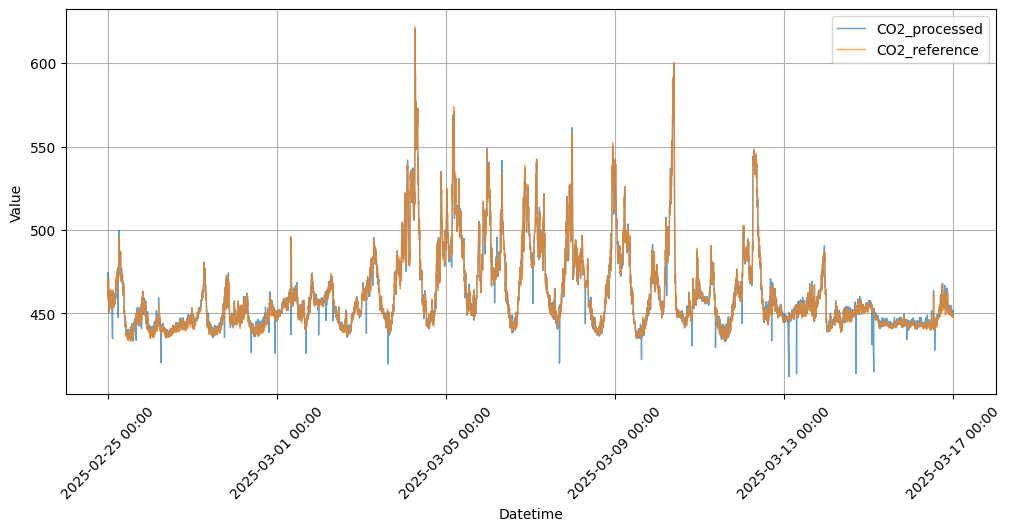

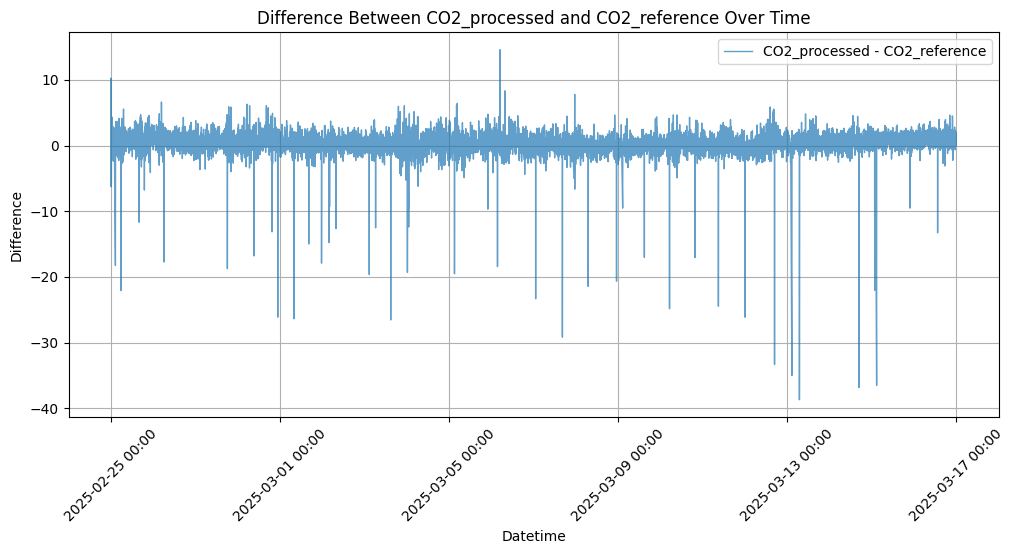

In [36]:
plot_columns(df_s_3, "datetime", ["CO2_processed", "CO2_reference"])
plot_column_difference(df_s_3, "datetime", ["CO2_processed", "CO2_reference"])

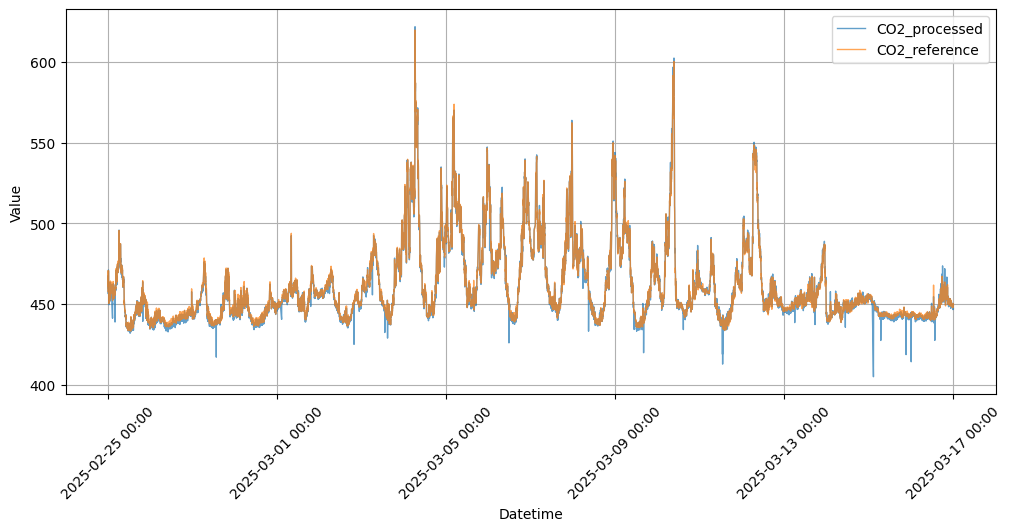

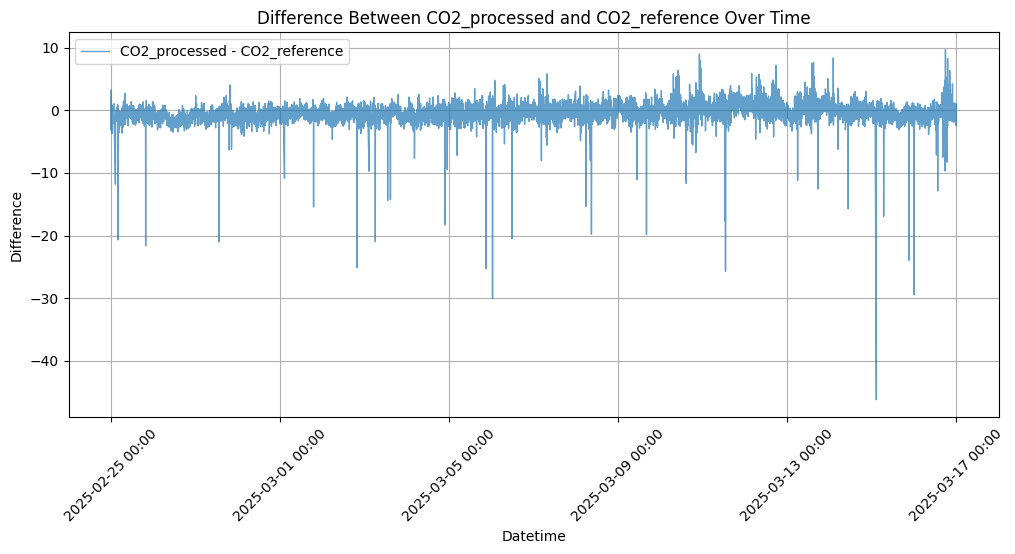

In [37]:
plot_columns(df_s_6, "datetime", ["CO2_processed", "CO2_reference"])
plot_column_difference(df_s_6, "datetime", ["CO2_processed", "CO2_reference"])

# Versuch: Berechnung von Mean, MAE und RMSE

In diesem Versuch analysieren wir Zeitreihen von Sensordaten und zugehörigen Referenzdaten. Ziel ist es, verschiedene Performance-Metriken zu implementieren und zu berechnen, die uns helfen, die Genauigkeit und Qualität der Sensorsignale zu bewerten.

## Hintergrund und Motivation

Sensordaten können von Rauschen, Ausreißern und systematischen Abweichungen beeinflusst werden. Um die Leistung eines Sensorsystems zu beurteilen, vergleichen wir die gemessenen Daten mit Referenzwerten. Dabei sind folgende Metriken von besonderem Interesse:

- **Mean (Mittelwert):**  
  Der Durchschnittswert der Daten, der einen allgemeinen Überblick über die Lage der Messwerte gibt.

  $$
  \text{Mean} = \frac{1}{n} \sum_{i=1}^{n} y_i
  $$

- **Mean Absolute Error (MAE):**  
  Der durchschnittliche absolute Fehler zwischen den Sensordaten und den Referenzdaten. Er zeigt, wie stark die Messwerte im Durchschnitt von den tatsächlichen Werten abweichen.

  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
  $$

- **Root Mean Squared Error (RMSE):**  
  Die Quadratwurzel des durchschnittlichen quadrierten Fehlers. Da hier größere Abweichungen stärker gewichtet werden, reagiert der RMSE empfindlicher auf Ausreißer.

  $$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
  $$

Diese Metriken liefern unterschiedliche Perspektiven auf die Datenqualität: Während der Mittelwert den zentralen Tendenzwert beschreibt, zeigen MAE und RMSE, wie gut (oder schlecht) die Sensordaten mit den Referenzwerten übereinstimmen. Insbesondere der RMSE hebt größere Fehler hervor, was bei der Identifikation von Ausreißern und systematischen Abweichungen hilfreich sein kann.

## Ziel des Versuchs

- **Implementierung der Performance-Metriken:**  
  Entwickelt Python-Funktionen zur Berechnung von Mean, MAE und RMSE.
  
- **Vergleich der Metriken:**  
  Analysiert, wie sich die Metriken untereinander unterscheiden und welche Aussagekraft sie hinsichtlich der Sensorleistung haben.
  
- **Bewertung der Sensordaten:**  
  Wendet die Funktionen auf gegebene Zeitreihen von Sensordaten und Referenzdaten an, um die Genauigkeit des Sensors zu beurteilen und mögliche Kalibrierungsansätze zu diskutieren.

## Aufgabenstellung

1. **Implementierung der Metriken:**  
   Schreibt Python-Funktionen für Mean, MAE und RMSE

2. **Anwendung und Vergleich:**  
   Wendet die implementierten Funktionen auf die Zeitreihen an und vergleicht die Ergebnisse. Diskutiert, welche Metrik sich stärker an Ausreißern orientiert und welche Metrik als allgemeiner Indikator für die Messgenauigkeit dient.

# Hilreiche Funktionen

[Numpy Documentation](https://numpy.org/doc/2.1/reference/routines.math.html)

```
import numpy as np 

- np.mean([1, 2, 3, 4, 5]) -> np.float64(3.0)

- np.abs([-1, -2, -3, -4, -5]) -> array([1, 2, 3, 4, 5])

- np.sqrt([1, 4, 9, 16, 25]) -> array([1., 2., 3., 4., 5.])

- np.array([1, 2, 3, 4, 5]) ** 2 -> array([ 1,  4,  9, 16, 25])
```

# Praktische Übung 1

In [38]:
def mean(values: np.ndarray) -> float:
    """
    Berechnet den Mittelwert der gegebenen Werte.
    """
    # Implementierung des Mittelwerts
    
    return mean

def mae(sensor: np.ndarray, reference: np.ndarray) -> float:
    """
    Berechnet den Mean Absolute Error (MAE) zwischen den Sensor- und Referenzdaten.
    """
    # Implementierung des MAE
    
    return mae

def rmse(sensor: np.ndarray, reference: np.ndarray) -> float:
    """
    Berechnet den Root Mean Squared Error (RMSE) zwischen den Sensor- und Referenzdaten.
    """
    # Implementierung des RMSE
    
    return rmse

In [39]:
def mean(values: np.ndarray) -> float:
    """
    Berechnet den Mittelwert der gegebenen Werte.
    """
    return np.mean(values)

def mae(sensor: np.ndarray, reference: np.ndarray) -> float:
    """
    Berechnet den Mean Absolute Error (MAE) zwischen den Sensor- und Referenzdaten.
    """
    return np.mean(np.abs(sensor - reference))

def rmse(sensor: np.ndarray, reference: np.ndarray) -> float:
    """
    Berechnet den Root Mean Squared Error (RMSE) zwischen den Sensor- und Referenzdaten.
    """
    return np.sqrt(np.mean((sensor - reference) ** 2))

In [40]:
# Sensordaten und Referenzdaten als numpy arrays
sensor_3_data = df_s_3.select(pl.col("CO2_processed")).to_numpy()
reference_data = df_s_3.select(pl.col("CO2_reference")).to_numpy()

print("Mean (Sensor 3):", mean(sensor_3_data - reference_data))
print("MAE: (Sensor 3)", mae(sensor_3_data, reference_data))
print("RMSE: (Sensor 3)", rmse(sensor_3_data, reference_data))

sensor_6_data = df_s_6.select(pl.col("CO2_processed")).to_numpy()
reference_data = df_s_6.select(pl.col("CO2_reference")).to_numpy()

print("Mean (Sensor 6):", mean(sensor_6_data - reference_data))
print("MAE: (Sensor 6)", mae(sensor_6_data, reference_data))
print("RMSE: (Sensor 6)", rmse(sensor_6_data, reference_data))

Mean (Sensor 3): 0.3518541885146903
MAE: (Sensor 3) 1.1044634964210875
RMSE: (Sensor 3) 1.8988939438316637
Mean (Sensor 6): -0.43237901764373793
MAE: (Sensor 6) 1.0759301930097382
RMSE: (Sensor 6) 1.8243936357323267


Fragen:

- Wieso unterscheiden sich die Werte?
- Was ist der treibende Faktor im Unterschied zwischen MAE und RMSE?

--- 

# Versuch: Anwendung des Hampel-Filters zur Ausreißerentfernung

In diesem Versuch erarbeiten wir, wie ein Hampel-Filter eingesetzt werden kann, um Ausreißer aus einem Sensorsignal zu entfernen. Ziel ist es, die Qualität und Aussagekraft der Messdaten zu verbessern, bevor weitere Analysen (z. B. Zeitaggregation und Performance-Metriken) durchgeführt werden.

## Hintergrund

Sensordaten sind häufig von zufälligen Störungen und Ausreißern betroffen, die durch Fehler in der Messung, vorübergehende Störungen oder andere Anomalien verursacht werden können. Solche Ausreißer können die statistische Analyse und die Berechnung von Kennzahlen erheblich verfälschen. 

Der **Hampel-Filter** ist ein robustes Verfahren zur Identifikation und Korrektur von Ausreißern in Zeitreihen. Er basiert auf dem Median und der Median Absolute Deviation (MAD) und bietet den Vorteil, dass er im Vergleich zu anderen Methoden (z. B. dem Z-Score) weniger anfällig für Verzerrungen durch extreme Werte ist.

## Ziel des Versuchs

- **Ausreißererkennung:**  
  Identifiziert einzelne Datenpunkte, die signifikant von den umgebenden Werten abweichen.

- **Signalbereinigung:**  
  Entfernt oder ersetzt diese Ausreißer, um ein glatteres, repräsentativeres Sensorsignal zu erhalten.

- **Vorbereitung für weitere Analysen:**  
  Ein sauberes Signal ermöglicht genauere Zeitaggregation und die Berechnung von Performance-Metriken (wie Mean, MAE, RMSE), die für die Bewertung der Sensorleistung wichtig sind.

# Mathematische Funktion des Hampel-Filters

Der Hampel-Filter ist ein robustes Verfahren zur Identifikation und Korrektur von Ausreißern in Zeitreihen. Im Folgenden wird die mathematische Funktionsweise des Filters erläutert.

## Vorgehensweise im Detail

Gegeben sei eine Zeitreihe

$$
x_1, x_2, \ldots, x_N.
$$

Für jeden Datenpunkt $x_i$ wird in einem festgelegten Fenster (zum Beispiel von $i - k$ bis $i + k$) Folgendes berechnet:

1. **Median im Fenster:**  
   Definiert den Median der Werte im Fenster als

   $$
   m_i = \text{median}\{x_{i-k}, x_{i-k+1}, \ldots, x_{i+k}\}.
   $$

2. **Median Absolute Deviation (MAD):**  
   Berechnet die mittlere absolute Abweichung der Werte vom Median im selben Fenster:

   $$
   \text{MAD}_i = \text{median}\{|x_j - m_i| : j = i-k, \ldots, i+k\}.
   $$

3. **Ausreißererkennung:**  
   Ein Datenpunkt $x_i$ wird als Ausreißer klassifiziert, wenn die Abweichung vom Median einen vorgegebenen Schwellenwert überschreitet. Konkret wird geprüft, ob

   $$
   |x_i - m_i| > t \cdot \text{MAD}_i,
   $$

   wobei $t$ ein Schwellenfaktor (typischerweise z. B. 3) ist. Für normalverteilte Daten kann der Faktor $t$ mit dem Multiplikator (etwa 1.4826) kombiniert werden, um die MAD in eine Schätzung der Standardabweichung zu überführen, falls dies erforderlich ist.

4. **Korrektur der Ausreißer:**  
   Ist die Bedingung erfüllt, wird $x_i$ als Ausreißer betrachtet und üblicherweise durch den Median $m_i$ des Fensters ersetzt. Andernfalls bleibt der Wert unverändert.

## Zusammenfassung der Filterfunktion

Der Hampel-Filter transformiert den ursprünglichen Signalwert $x_i$ zu einem gefilterten Wert $\hat{x}_i$ nach folgender Regel:

$$
\hat{x}_i = 
\begin{cases}
m_i, & \text{wenn } |x_i - m_i| > t \cdot \text{MAD}_i, \\
x_i, & \text{sonst}.
\end{cases}
$$

Diese Methode ist robust gegenüber Ausreißern, da der Median und die MAD wesentlich weniger empfindlich gegenüber extremen Werten sind als arithmetische Mittel und Standardabweichung.

# Praktische Übung 2

## System 3

Detektierte Ausreißer: 0.8471%
Mean (Sensor 3): 0.4038079616381227
MAE: (Sensor 3) 1.0465233619857977
RMSE: (Sensor 3) 1.4685988695523262


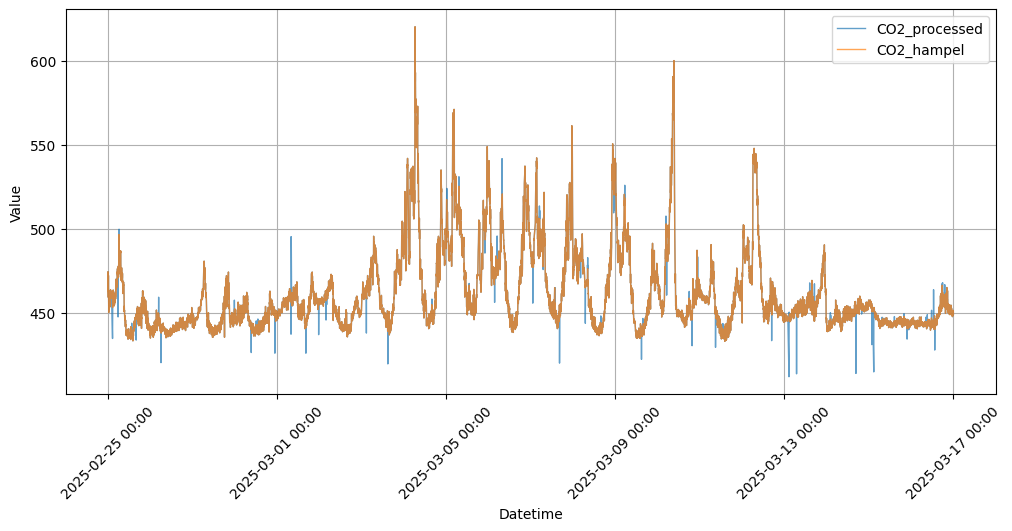

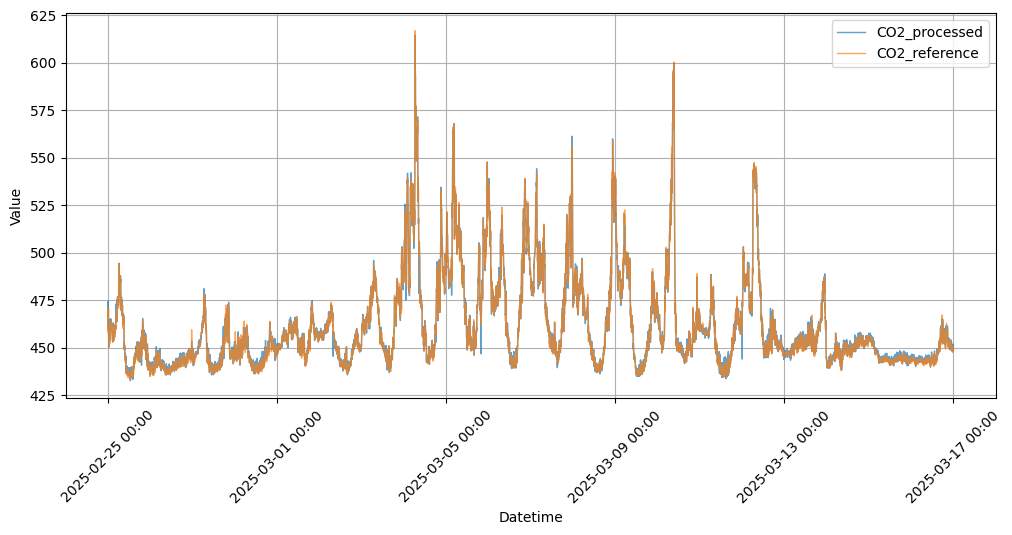

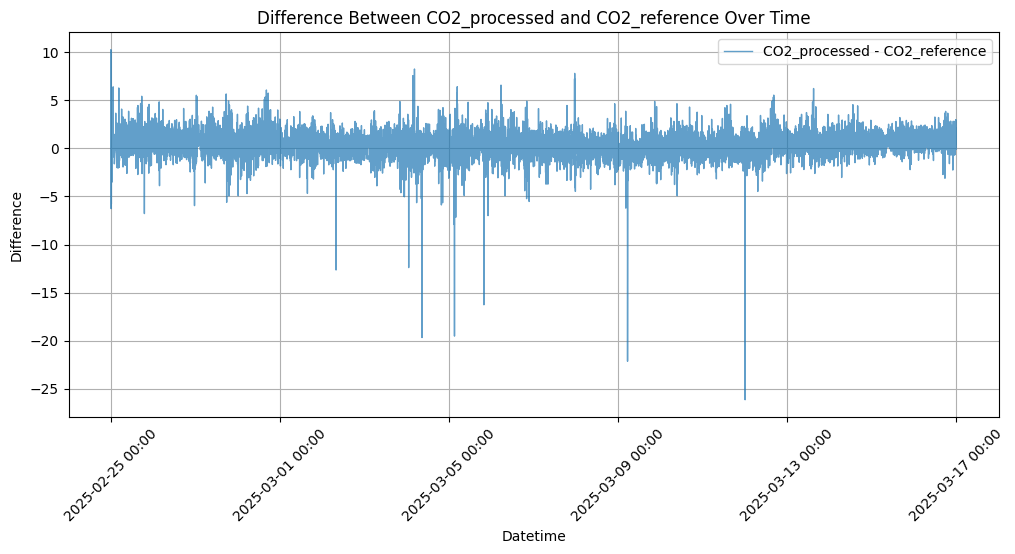

In [41]:
## Verändere nachfolgende Parameter
window_size = 120
n_sigma = 3.0
##

# Convert CO2 column to pandas series
data = df_s_3.get_column("CO2_processed").to_numpy()

# Apply the Hampel filter
result = hampel(data,
                window_size=window_size,
                n_sigma=n_sigma)

# Print share of detected spikes
print(f"Detektierte Ausreißer: {(len(result.outlier_indices) / len(data))* 100:.4f}%")

# Create column "Flag" = 'H' indicating outlier
df_s_3 = df_s_3.with_columns(pl.Series("CO2_hampel", result.filtered_data)) \
    .cast({"CO2_hampel": pl.Float64}) \
    .with_columns(
    [
        pl.col("CO2_processed").round(2),
        pl.col("CO2_hampel").round(2),
    ]
    ) \
    .with_columns(pl.when(pl.col("CO2_processed").ne(pl.col("CO2_hampel"))).then(pl.lit('H')).otherwise(pl.lit('U')).alias("Flag"))
    
df_s_3_filtered = df_s_3.filter(pl.col("Flag") == "U")

sensor_3_data = df_s_3_filtered.select(pl.col("CO2_processed")).to_numpy()
reference_data = df_s_3_filtered.select(pl.col("CO2_reference")).to_numpy()

# Performance metrics
print("Mean (Sensor 3):", mean(sensor_3_data - reference_data))
print("MAE: (Sensor 3)", mae(sensor_3_data, reference_data))
print("RMSE: (Sensor 3)", rmse(sensor_3_data, reference_data))
    
# Plot
plot_columns(df_s_3, "datetime", ["CO2_processed", "CO2_hampel"])
plot_columns(df_s_3_filtered, "datetime", ["CO2_processed", "CO2_reference"])
plot_column_difference(df_s_3_filtered, "datetime", ["CO2_processed", "CO2_reference"])

## System 6

Detektierte Ausreißer: 0.7909%
Mean (Sensor 6): -0.3871001694731943
MAE: (Sensor 6) 1.0204159556302381
RMSE: (Sensor 6) 1.417041449062432


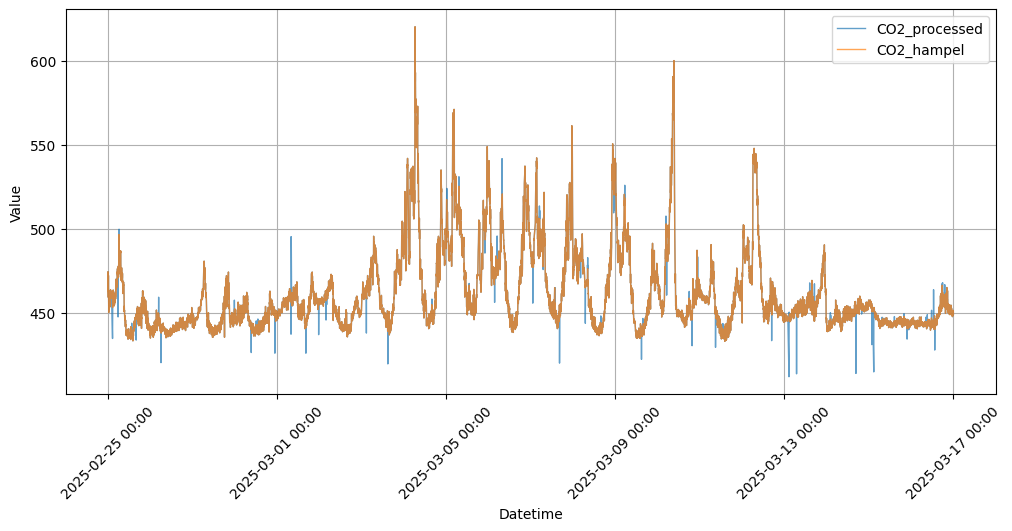

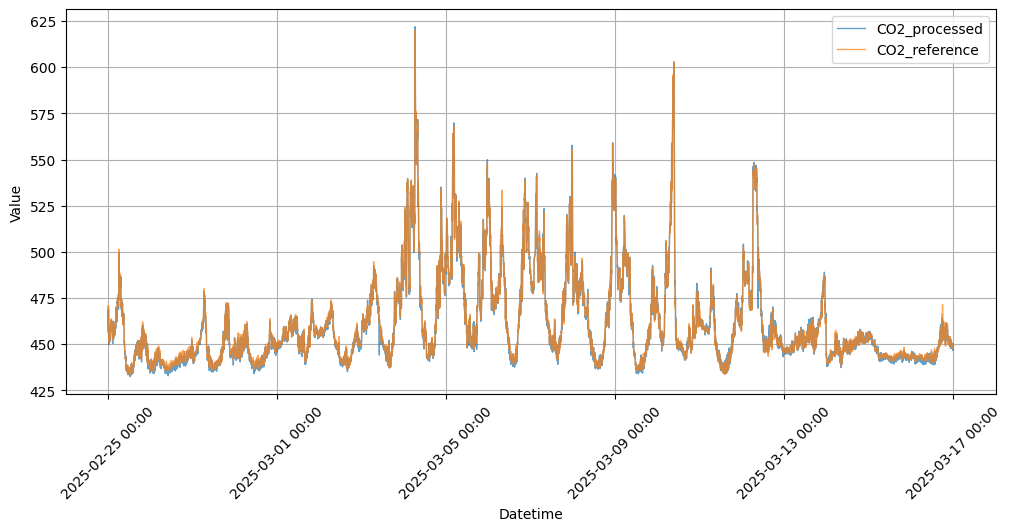

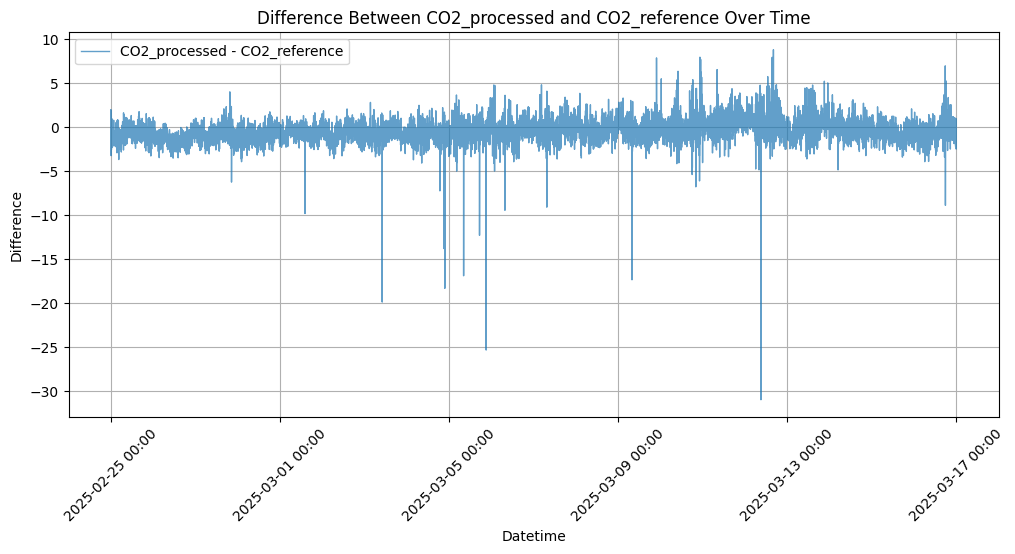

In [45]:
## Verändere nachfolgende Parameter
window_size = 120
n_sigma = 3.0
##

# Convert CO2 column to pandas series
data = df_s_6.get_column("CO2_processed").to_numpy()

# Apply the Hampel filter
result = hampel(data,
                window_size=window_size,
                n_sigma=n_sigma)

# Print share of detected spikes
print(f"Detektierte Ausreißer: {(len(result.outlier_indices) / len(data))* 100:.4f}%")

# Create column "Flag" = 'H' indicating outlier
df_s_6 = df_s_6.with_columns(pl.Series("CO2_hampel", result.filtered_data)) \
    .cast({"CO2_hampel": pl.Float64}) \
    .with_columns(
    [
        pl.col("CO2_processed").round(2),
        pl.col("CO2_hampel").round(2),
    ]
    ) \
    .with_columns(pl.when(pl.col("CO2_processed").ne(pl.col("CO2_hampel"))).then(pl.lit('H')).otherwise(pl.lit('U')).alias("Flag")) \
    

df_s_6_filtered = df_s_6.filter(pl.col("Flag") == "U")

sensor_6_data = df_s_6_filtered.select(pl.col("CO2_processed")).to_numpy()
reference_data = df_s_6_filtered.select(pl.col("CO2_reference")).to_numpy()

# Performance metrics
print("Mean (Sensor 6):", mean(sensor_6_data - reference_data))
print("MAE: (Sensor 6)", mae(sensor_6_data, reference_data))
print("RMSE: (Sensor 6)", rmse(sensor_6_data, reference_data))
   
# Plot
plot_columns(df_s_3, "datetime", ["CO2_processed", "CO2_hampel"]) 
plot_columns(df_s_6_filtered, "datetime", ["CO2_processed", "CO2_reference"])
plot_column_difference(df_s_6_filtered, "datetime", ["CO2_processed", "CO2_reference"])

---

# Versuch: Zeitaggregation und Performance-Metriken

In diesem Versuch werden hochfrequente Sensordaten, die beispielsweise im 1-Minuten-Takt vorliegen, zunächst in Zeitfenstern von **x Minuten** aggregiert. Ziel ist es, kurzfristige Schwankungen und Rauschen zu reduzieren, sodass stabilere und aussagekräftigere Trends erkennbar werden. Anschließend vergleichen wir die aggregierten Sensordaten mit den zugehörigen Referenzdaten und bewerten die Leistung des Sensorsystems anhand von Performance-Metriken wie Mean, MAE und RMSE.

## Hintergrund und Motivation

Hochfrequente Messungen können durch zufällige Schwankungen und Ausreißer beeinträchtigt sein. Die **Zeitaggregation** dient dazu, diese kurzfristigen Variationen zu glätten, indem beispielsweise der Mittelwert über jedes x-Minuten-Fenster berechnet wird. Dadurch wird das Signal stabilisiert, was die anschließende Analyse erleichtert.

## Ziel des Versuchs

- **Zeitaggregation:**  
  Aggregiert die hochfrequenten Sensordaten in x-Minuten-Zeitfenster, um ein rauscharmes Signal zu erhalten.

- **Performance-Bewertung:**  
  Berechnet anhand der aggregierten Daten die Kennzahlen Mean, MAE und RMSE, um die Genauigkeit des Sensorsignals im Vergleich zu Referenzdaten zu bewerten.

- **Analyse und Vergleich:**  
  Untersucht, wie sich unterschiedliche Aggregationsintervalle auf die Performance-Metriken auswirken und welche Aggregationsstrategie zu stabileren und präziseren Messwerten führt.

## Aufgabenstellung

1. **Datenaggregation:**  
   - Aggregiert die Sensordaten in Zeitfenstern von x Minuten (z. B. durch Berechnung des Mittelwerts).

2. **Analyse:**  
   - Diskutiert, wie sich die Wahl des Aggregationsintervalls auf die Performance-Metriken auswirkt.
   - Diskutiert, wie stark sich ein Vezug zwischen Timestamps im Mess- und Referenzsignal auf das gewählt Aggregationsintervall auswirkt
   - Diskutiert, was einen Verzug zwischen einen Mess- und Referenzsignal auslösen kann

# Hilreiche Funktionen

### Already Imported

```Python
import polars as pl
import polars.selectors as cs
```

### Dataframe Documentation
[Polars Documentation](https://docs.pola.rs/api/python/stable/reference/dataframe/index.html)

### Useful Polars Functions
[Groupy By Dynamic](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.group_by_dynamic.html#polars.DataFrame.group_by_dynamic)

[Aggregation](https://docs.pola.rs/api/python/stable/reference/dataframe/aggregation.html)

[Selector](https://docs.pola.rs/api/python/stable/reference/selectors.html#module-polars.selectors)

[Pipe](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.pipe.html#polars.DataFrame.pipe)

In [ ]:
def time_aggregation(df: pl.DataFrame, interval="1m") -> pl.DataFrame:
    """
    Aggregiert die Daten in X-Minuten-Intervallen.
    
    Receives a dataframe as df
    
    Returns a dataframe with the aggregated data.
    """
    # Aggregation
    df = df
    
    return df

In [ ]:
## Verändere nachfolgende Parameter
interval = '1m'
##
  
# Applies the function using the pipe method
df_s_3_aggregated = df_s_3_filtered.pipe(time_aggregation, interval)       
df_s_6_aggregated = df_s_6_filtered.pipe(time_aggregation, interval)

In [ ]:
sensor_3_data = df_s_3_aggregated.select(pl.col("CO2_processed")).to_numpy()
reference_data = df_s_3_aggregated.select(pl.col("CO2_reference")).to_numpy()

# Performance metrics
print("Mean (Sensor 3):", mean(sensor_3_data - reference_data))
print("MAE: (Sensor 3)", mae(sensor_3_data, reference_data))
print("RMSE: (Sensor 3)", rmse(sensor_3_data, reference_data))


sensor_6_data = df_s_6_aggregated.select(pl.col("CO2_processed")).to_numpy()
reference_data = df_s_6_aggregated.select(pl.col("CO2_reference")).to_numpy()

# Performance metrics
print("Mean (Sensor 6):", mean(sensor_6_data - reference_data))
print("MAE: (Sensor 6)", mae(sensor_6_data, reference_data))
print("RMSE: (Sensor 6)", rmse(sensor_6_data, reference_data))

Mean (Sensor 3): 0.4038079616381227
MAE: (Sensor 3) 1.0465233619857977
RMSE: (Sensor 3) 1.4685988695523262
Mean (Sensor 6): -0.3871001694731943
MAE: (Sensor 6) 1.0204159556302381
RMSE: (Sensor 6) 1.417041449062432
